In [456]:
!pip install scikit-learn
!pip install skccm

In [492]:
import pandas as pd
import numpy as np
np.seterr(divide='ignore')
import matplotlib.pyplot as plt


def collect_log_data(file_name):
    """
    Parses log data for PlayerLog
    Breaks in episode by detecting Score
    """
    lines = []
    scores = []
    with open("../"+file_name, "rt") as fh:
        episode=0
        step=0
        for line in fh:
            if line.startswith("PlayerLog"):
                item = line.strip().replace("PlayerLog: ","").split("position")
                if len(item) == 2:
                    agent, coords = item
                    x,z,y=coords.strip().replace("is: ","").strip("()").replace(" ","").split(",")
                    lines.append([agent.strip(), x, y, (float(x),float(y)), step, episode])
                    step+=1
                else:
                    if "Scored" in item[0]:
                        scores.append(item[0])
                        episode+=1
                        step=0
                    
    return lines, scores

def write_log_data(file_name):
    try:
        lines, scores = collect_log_data(file_name)                 
        df_poca = make_games_df(lines)
        df_scores_poca = pd.DataFrame(zip(range(len(scores)), scores), columns=['episode','score'])

        df_poca.to_csv(file_name.replace(".log","")+"_AgentGameData.csv")
        df_scores_poca.to_csv(file_name.replace(".log","")+"_AgentScoresData.csv")
        return "Done"
    except FileNotFoundError:
        print(f"no log data found for {file_name}")




def make_games_df(lines):
    df = pd.DataFrame(lines, columns=['agent','x','y','pos','step','episode'])
    df = df.set_index("agent")
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    return df

def plot_a_game(df, game, title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    df.query(f"episode == {game}").loc['Ball'].tail(3).plot.line(x="x", y="y", label="Ball", c='black', ax=ax)
    df.query(f"episode == {game}").loc['Ball'].plot.scatter(x="x", y="y", label="Ball", c='black', ax=ax)
    df.query(f"episode == {game}").loc['Blue Agent1'].plot.scatter(x="x", y="y", label="BlueTeamAgent1", c='lightblue', ax=ax)
    df.query(f"episode == {game}").loc['Blue Agent2'].plot.scatter(x="x", y="y", label="BlueTeamAgent2", c='blue', ax=ax)
    df.query(f"episode == {game}").loc['Purple Agent1'].plot.scatter(x="x", y="y", label="RedTeamAgent1", c='orchid', ax=ax)
    df.query(f"episode == {game}").loc['Purple Agent2'].plot.scatter(x="x", y="y", label="RedTeamAgent2", c='purple', ax=ax)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.1, 1.05))


def distance(item):
    pos1, pos2=item[0], item[1]
    return np.sqrt( (pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)

import skccm as ccm

from skccm.utilities import train_test_split

def embed(x1, x2, lag=3, embed=2):
    e1 = ccm.Embed(x1)
    e2 = ccm.Embed(x2)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    return X1, X2

def forecast_skill(embedding, percent=0.75):
    X1, X2 = embedding
    #split the embedded time series 
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=percent)

    CCM = ccm.CCM() #initiate the class

    #library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

    #test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

    sc1,sc2 = CCM.score()
    return pd.DataFrame(zip(sc1, sc2), columns=['sc1','sc2'])

def collect_distances_per_episode(df, scores):
    df_cp = df.copy().reset_index()
    df_cp['pos'] = list(zip(df_cp['x'], df_cp['y']))
    blue_distance_dfs = []
    purple_distance_dfs = []
    for i in range(len(scores)-1):
        episode = i
        ba1_pos = df_cp[df_cp['agent'].isin(['Blue Agent1'])].query(f"episode == {episode}")['pos'].tolist()
        ba2_pos = df_cp[df_cp['agent'].isin(['Blue Agent2'])].query(f"episode == {episode}")['pos'].tolist()
        ra1_pos = df_cp[df_cp['agent'].isin(['Purple Agent1'])].query(f"episode == {episode}")['pos'].tolist()
        ra2_pos = df_cp[df_cp['agent'].isin(['Purple Agent2'])].query(f"episode == {episode}")['pos'].tolist()
        df_blue = pd.DataFrame(list(map(distance, zip(ba1_pos, ba2_pos))),columns=['BlueTeam'])
        df_purple = pd.DataFrame(list(map(distance, zip(ra1_pos, ra2_pos))),columns=['PurpleTeam'])
        if 'Blue' in scores[episode]:
            df_blue['blue_team_scored'] = 1
            df_purple['purple_team_scored'] = 0
        else:
            df_blue['blue_team_scored'] = 0
            df_purple['purple_team_scored'] = 1
        df_blue['episode'] = episode
        df_purple['episode'] = episode
        df_blue.loc[df_blue.shape[0]-1, 'is_final_step'] = 1
        df_purple.loc[df_purple.shape[0]-1, 'is_final_step'] = 1
        blue_distance_dfs.append(df_blue)
        purple_distance_dfs.append(df_purple)
    blue_distance_df=pd.concat(blue_distance_dfs)
    blue_distance_df = blue_distance_df.fillna(0)
    purple_distance_df=pd.concat(purple_distance_dfs)
    purple_distance_df = purple_distance_df.fillna(0)

    df_distances = pd.DataFrame(range(len(scores)-1), columns=['episode']).merge(purple_distance_df.query("is_final_step == 1").drop(columns=['is_final_step']), how="left")
    df_distances = df_distances.merge(blue_distance_df.query("is_final_step == 1").drop(columns=['is_final_step']), how="left") 
    return df_distances

def collect_forecasts(df, scores):
    results_forecast = []
    for episode_n in range(len(scores)-1):
        
        x1 = df.query(f"episode =={episode_n} & agent == 'Blue Agent1'")["x"].values
        x2 = df.query(f"episode == {episode_n} & agent == 'Blue Agent2'")["x"].values   
        if len(x1) > 20:
            forecast = forecast_skill(embed(x1, x2))
            max_forecast = forecast.max().max()
            mean_forecast = forecast.mean().max()
            results_forecast.append([episode_n, max_forecast, mean_forecast])
    df_results_forecast = pd.DataFrame(results_forecast, columns=['episode', 'max_skill', 'mean_skill'])
    return df_results_forecast
    
file_name_poca = "POCA_LastCheckpoint.log"
file_name_poca_ck1 = "POCA_Checkpoint1.log"
file_name_poca_hf = "POCA_HalfTrained_lr.log"
file_name_ppo = "PPO_LastCheckpoint.log"      

all_files = [
    file_name_poca,
    file_name_poca_ck1,
    file_name_poca_hf,
    file_name_ppo
    ]

#[write_log_data(f) for f in all_files]




In [478]:
import glob
print(glob.glob("*_AgentGameData.csv"))
poca_full_df = pd.read_csv('POCA_LastCheckpoint_AgentGameData.csv')
poca_full_scores = pd.read_csv('POCA_LastCheckpoint_AgentScoresData.csv')['score'].tolist()

poca_half_df = pd.read_csv('POCA_HalfTrained_lr_AgentGameData.csv')
poca_half_scores = pd.read_csv('POCA_HalfTrained_lr_AgentScoresData.csv')['score'].tolist()

ppo_full_df = pd.read_csv('PPO_LastCheckpoint_AgentGameData.csv')
ppo_full_scores = pd.read_csv('PPO_LastCheckpoint_AgentScoresData.csv')['score'].tolist()

['POCA_Checkpoint1_AgentGameData.csv', 'POCA_HalfTrained_lr_AgentGameData.csv', 'POCA_LastCheckpoint_AgentGameData.csv', 'PPO_LastCheckpoint_AgentGameData.csv']


In [493]:

df_distances_poca = collect_distances_per_episode(poca_full_df, poca_full_scores)
df_results_forecast_poca = collect_forecasts(poca_full_df, poca_full_scores)

df_distances_hpoca = collect_distances_per_episode(poca_half_df, poca_half_scores)
df_results_forecast_hpoca = collect_forecasts(poca_half_df, poca_half_scores)

df_distances_ppo = collect_distances_per_episode(ppo_full_df, ppo_full_scores)
df_results_forecast_ppo = collect_forecasts(ppo_full_df, ppo_full_scores)

/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/vlad/miniconda3/envs/mlagents/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: in

In [499]:
df_results_forecast_poca = df_results_forecast_poca.rename(columns={"max_skill":"max_skill_poca","mean_skill":"mean_skill_poca"})
df_results_forecast_hpoca = df_results_forecast_hpoca.rename(columns={"max_skill":"max_skill_hpoca","mean_skill":"mean_skill_hpoca"})
df_results_forecast_ppo = df_results_forecast_ppo.rename(columns={"max_skill":"max_skill_ppo","mean_skill":"mean_skill_ppo"})

Text(0.5, 0, 'Average Forecast Skill per game')

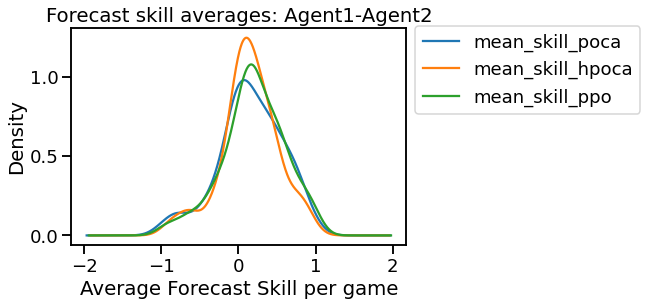

In [520]:
df_skills_mean = df_results_forecast_poca.merge(df_results_forecast_hpoca).merge(df_results_forecast_ppo)[['mean_skill_poca','mean_skill_hpoca','mean_skill_ppo']]
df_skills_mean.plot.density()
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title("Forecast skill averages: Agent1-Agent2")
plt.xlabel("Average Forecast Skill per game")

In [515]:
df_skills_mean.describe()

,mean_skill_poca,mean_skill_hpoca,mean_skill_ppo
count,233.000000,233.000000,233.000000
mean,0.156401,0.138202,0.191840
std,0.419413,0.371512,0.404789
min,-0.983509,-0.949018,-0.960526
25%,-0.061747,-0.032080,-0.008653
50%,0.162132,0.139592,0.187072
75%,0.456187,0.355121,0.464341
max,0.984016,0.985615,0.999195


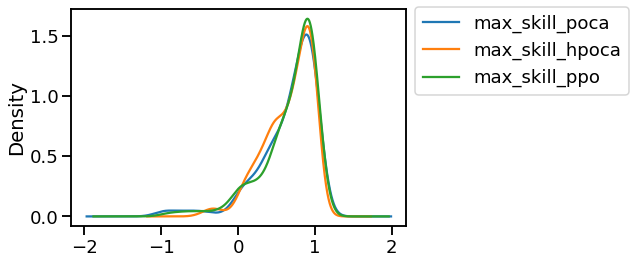

In [517]:
df_skills_max = df_results_forecast_poca.merge(df_results_forecast_hpoca).merge(df_results_forecast_ppo)[['max_skill_poca','max_skill_hpoca','max_skill_ppo']]
df_skills_max.plot.density()
plt.legend(bbox_to_anchor=(1, 1.05))

In [518]:
df_skills_max.describe()

,max_skill_poca,max_skill_hpoca,max_skill_ppo
count,233.000000,233.000000,233.000000
mean,0.648753,0.656671,0.666845
std,0.385664,0.309696,0.366529
min,-0.979262,-0.453615,-0.920322
25%,0.487285,0.459892,0.528903
50%,0.752005,0.747424,0.802017
75%,0.934318,0.922388,0.935618
max,0.999659,0.999780,0.999508


Text(0.5, 1.0, 'Purple Team Scored')

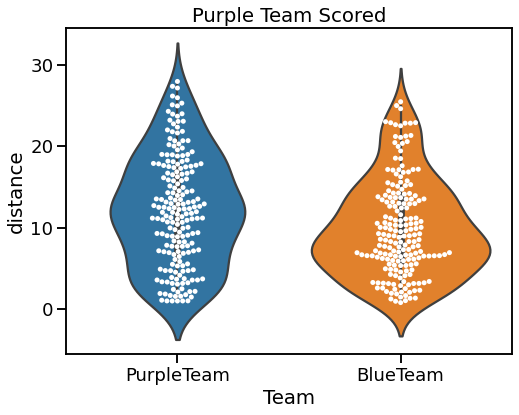

In [510]:
import seaborn as sns
sns.set_context("talk", font_scale=1.1)
df_plot = df_distances_poca.melt(id_vars=['episode','purple_team_scored'], value_vars=['PurpleTeam','BlueTeam'], var_name="Team", value_name='distance')
df_plot = df_plot.query("purple_team_scored == 1")  
plt.figure(figsize=(8,6))
sns.violinplot(y='distance', 
                x='Team', 
                data=df_plot)
sns.swarmplot(y='distance', 
                x='Team', 
                data=df_plot, 
                   color="white", edgecolor="gray")
plt.title("Purple Team Scored")                  

Text(0.5, 1.0, 'Blue Team Scored')

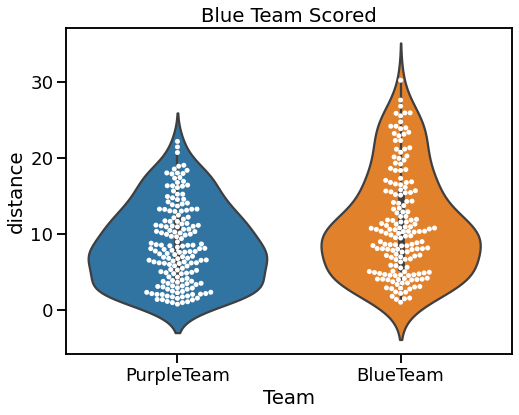

In [511]:
import seaborn as sns
#sns.set_context("talk", font_scale=1.1)
df_plot = df_distances_poca.melt(id_vars=['episode','purple_team_scored'], value_vars=['PurpleTeam','BlueTeam'], var_name="Team", value_name='distance')
df_plot = df_plot.query("purple_team_scored == 0")  
plt.figure(figsize=(8,6))
sns.violinplot(y='distance', 
                x='Team', 
                data=df_plot)
sns.swarmplot(y='distance', 
                x='Team', 
                data=df_plot, 
                   color="white", edgecolor="gray")

plt.title("Blue Team Scored") 

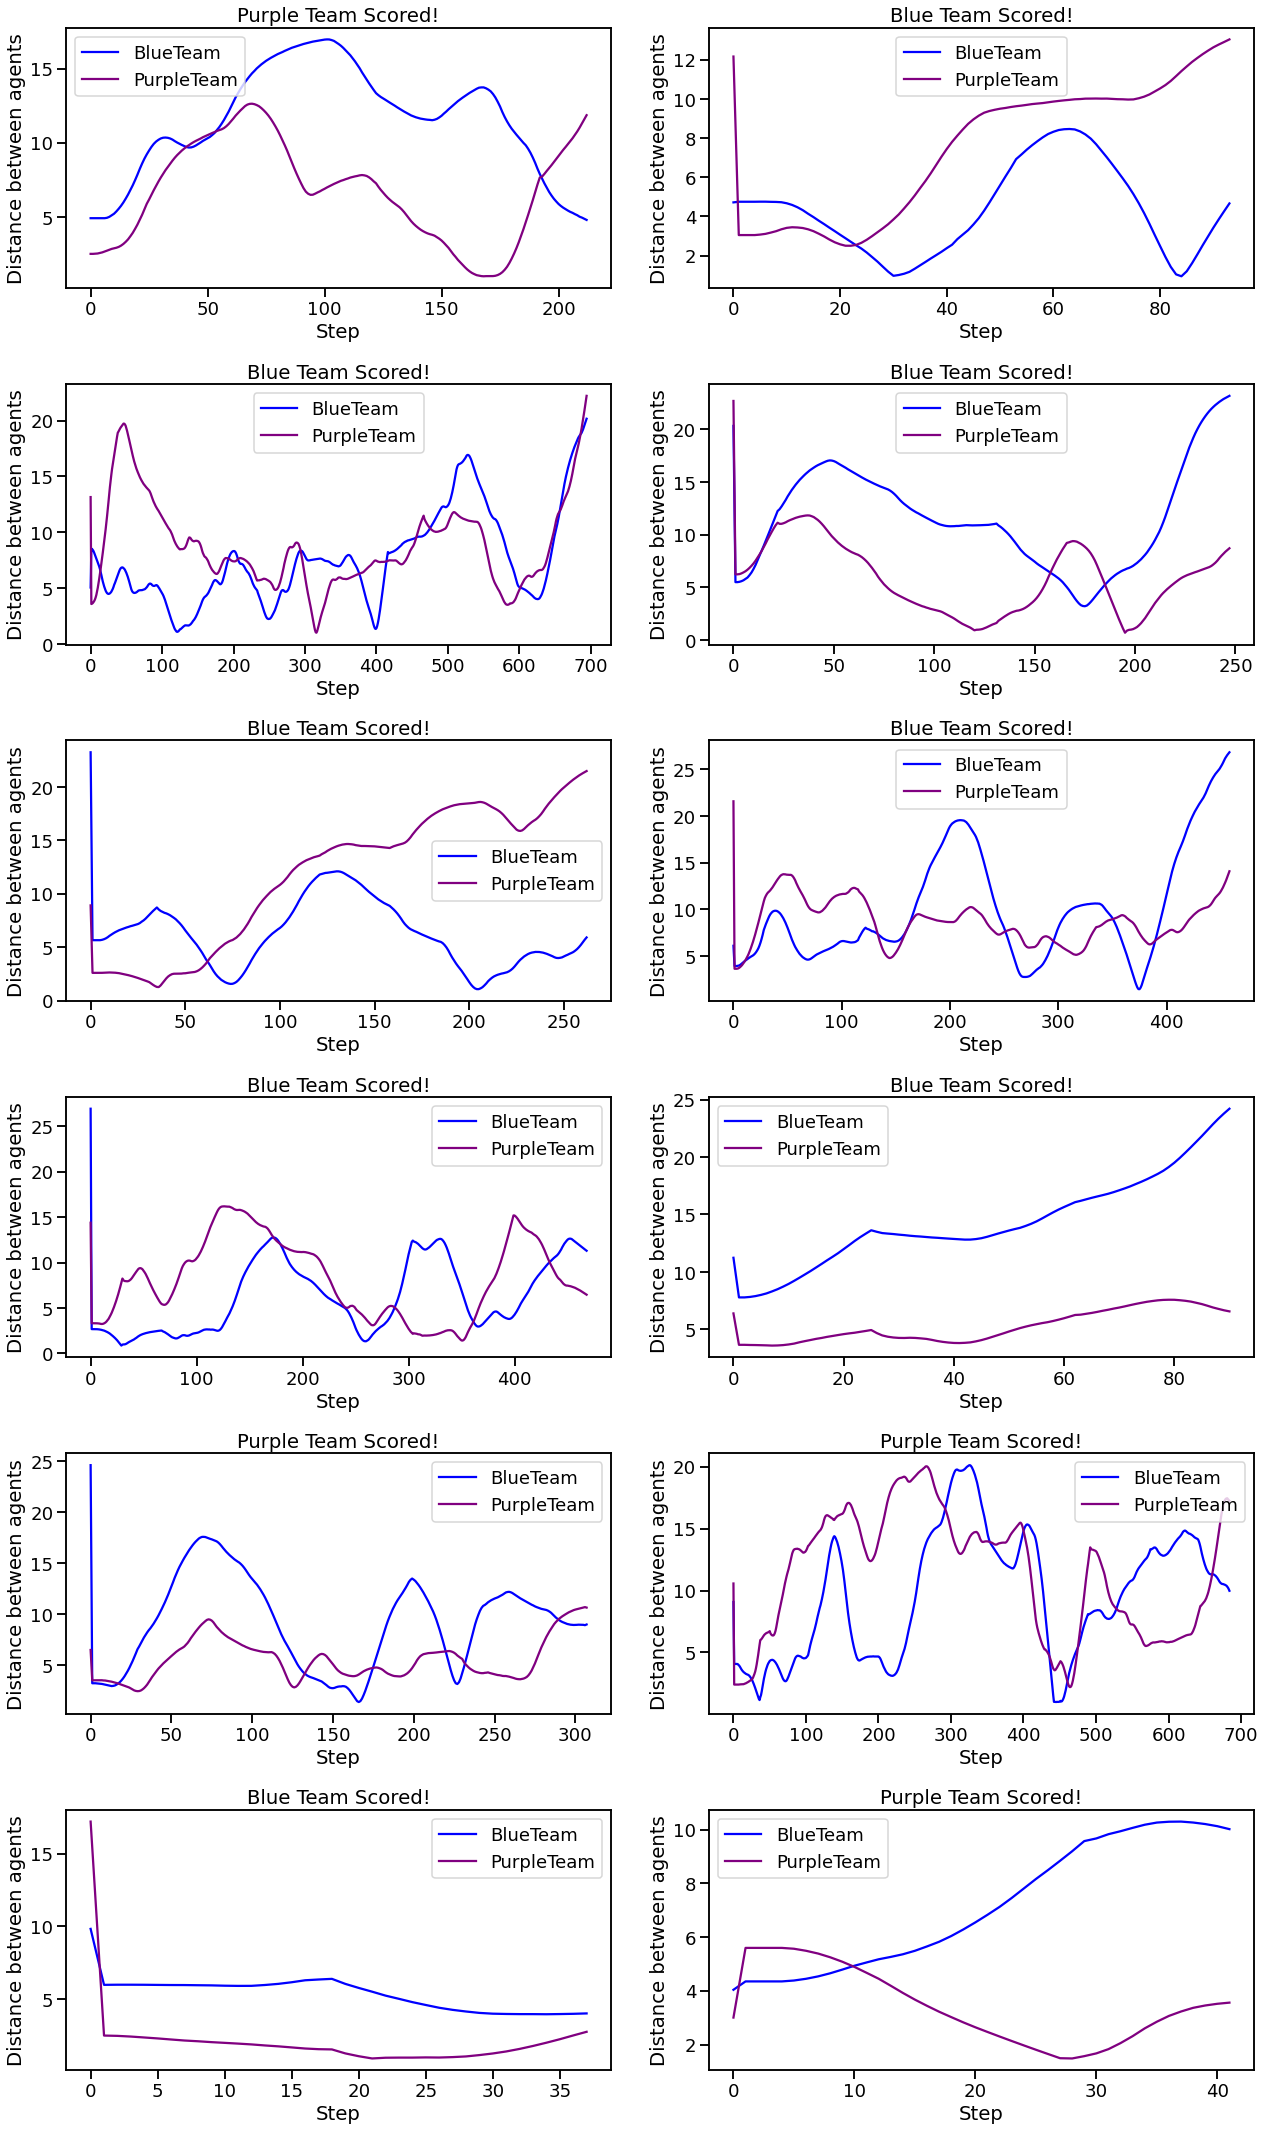

In [507]:
import matplotlib.pyplot as plt
df_cp = poca_full_df.copy().reset_index()
df_cp['pos'] = list(zip(df_cp['x'], df_cp['y']))
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(18, 30))
for i in range(12):
    c, r = i % 2, i // 2
    episode = i
    ba1_pos = df_cp[df_cp['agent'].isin(['Blue Agent1'])].query(f"episode == {episode}")['pos'].tolist()
    ba2_pos = df_cp[df_cp['agent'].isin(['Blue Agent2'])].query(f"episode == {episode}")['pos'].tolist()
    ra1_pos = df_cp[df_cp['agent'].isin(['Purple Agent1'])].query(f"episode == {episode}")['pos'].tolist()
    ra2_pos = df_cp[df_cp['agent'].isin(['Purple Agent2'])].query(f"episode == {episode}")['pos'].tolist()
    pd.DataFrame(list(map(distance, zip(ba1_pos, ba2_pos))),columns=['BlueTeam']).plot(ax=ax[r][c], c='blue', label='BlueTeam')
    pd.DataFrame(list(map(distance, zip(ra1_pos, ra2_pos))),columns=['PurpleTeam']).plot(ax=ax[r][c], c='purple',  label='PurpleTeam')
    ax[r][c].legend()
    ax[r][c].set_xlabel("Step")
    ax[r][c].set_ylabel("Distance between agents")
    ax[r][c].set_title(poca_full_scores[episode])
plt.tight_layout()


Text(0.5, 1.0, 'Purple Team Scored!')

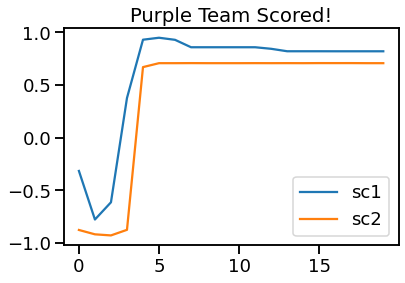

In [394]:
episode_n = 0
x1 = df_results_forecast_poca.query(f"episode =={episode_n} & agent == 'Blue Agent1'")["x"].values
x2 = df_results_forecast_poca.query(f"episode == {episode_n} & agent == 'Blue Agent2'")["x"].values

forecast = forecast_skill(embed(x1, x2))
forecast.plot()
plt.title(poca_full_scores[episode_n])

<AxesSubplot:>

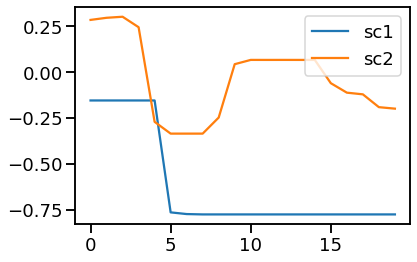

In [395]:
episode_n = 1
x1 = poca_full_scores.query(f"episode =={episode_n} & agent == 'Purple Agent1'")["x"].values
x2 = poca_full_scores.query(f"episode == {episode_n} & agent == 'Purple Agent2'")["x"].values

forecast = forecast_skill(embed(x1, x2))
forecast.plot()